In [1]:
# import pandas as pd
import numpy as np
import pandas as pd
file_path = '/kaggle/input/vindr-mammo-dataset/breast-level_annotations.csv'

df = pd.read_csv(file_path).head(2000)
df.loc[df['breast_birads'] == 'BI-RADS 1', 'breast_birads'] = '1'
df.loc[df['breast_birads'] == 'BI-RADS 2', 'breast_birads'] = '2'
df.loc[df['breast_birads'] == 'BI-RADS 3', 'breast_birads'] = '3'
df.loc[df['breast_birads'] == 'BI-RADS 4', 'breast_birads'] = '4'
df.loc[df['breast_birads'] == 'BI-RADS 5', 'breast_birads'] = '5'

df_new = df[['image_id', 'breast_birads']].copy()
groups = df_new.groupby('breast_birads')
group_names = list(groups.groups.keys())[0:5]

#foil_df+ explained_df (rank 2)
n1 = group_names[0]
c1_df = groups.get_group(n1).head(2).reset_index(drop=True)
print(c1_df)


#corpus_df(rank 4)
n2 = group_names[2]
c3_df = groups.get_group(n2).head(2).reset_index(drop=True)
print(c3_df)

#ex
n3 = group_names[1]
c2_df=groups.get_group(n3).tail(2).reset_index(drop=True)
x2_df=groups.get_group(n3).head(2).reset_index(drop=True)
print(c2_df)
print(x2_df)
image_folder = "/kaggle/input/vindr-mammo-dataset/Processed_Images"
# from img_id find img_path
def find_images(image_id, folder):
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file == image_id+'.png':
                image_paths=os.path.join(root, file)
    return image_paths

                           image_id breast_birads
0  dd9ce3288c0773e006a294188aadba8e             1
1  57fbdd278af5c8789a02b355c11620d4             1
                           image_id breast_birads
0  aad38467d1f04cedf300c9c8305a3536             3
1  2ccefd9e7701acf52c92275e844f7578             3
                           image_id breast_birads
0  5e65ff8020d615e6561df8aee72894ef             2
1  372aca2e23701e07dbec9ee47a8b1d86             2
                           image_id breast_birads
0  d8125545210c08e1b1793a5af6458ee2             2
1  290c658f4e75a3f83ec78a847414297c             2


In [2]:
import torch
mean =torch.tensor( [0.2652, 0.2652, 0.2652])#[ 0.7013, -0.1607, -0.7902]#[0.485, 0.456, 0.406]
std = torch.tensor([0.1994, 0.1994, 0.1994])#[0.5904, 0.5008, 0.3771]#[0.229, 0.224, 0.225]

import os
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader,random_split
from torch.utils.data import TensorDataset
import torchvision.transforms.functional as F_t

#creat dataset return tensor+ label
class MyDataset():
    def __init__(self, df, image_dir):
        self.image_ids = df.iloc[:, 0]  
        self.labels = df.iloc[:, 1]     
        self.image_dir = image_dir
        self.downsample_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
            ])
       
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image_id=self.image_ids.iloc[index]
        image_path=find_images(image_id,self.image_dir)
        image = Image.open(image_path)
        do = self.downsample_transform(image)
        tensor = torch.cat([do, do, do], dim=0)
        normalized_tensor = F_t.normalize(tensor, mean=mean, std=std)
        #normalized_tensor=do
        label = self.labels.iloc[index]
        return normalized_tensor,label

In [3]:
c1_dataset=MyDataset(c1_df,image_folder)
c2_dataset=MyDataset(c2_df,image_folder)
c3_dataset=MyDataset(c3_df,image_folder)
x2_dataset=MyDataset(x2_df,image_folder)

c1_dataloader=DataLoader(c1_dataset, batch_size=1, shuffle=False)
c2_dataloader=DataLoader(c2_dataset, batch_size=1, shuffle=False)
c3_dataloader=DataLoader(c3_dataset, batch_size=1, shuffle=False)
x2_dataloader=DataLoader(x2_dataset, batch_size=1, shuffle=False)

In [4]:
for x,y in c1_dataloader:
    print(x.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


In [5]:
# --------------------------------------------------------
# SimMIM
# Copyright (c) 2021 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Based on BEIT code bases (https://github.com/microsoft/unilm/tree/master/beit)
# Written by Yutong Lin, Zhenda Xie
# --------------------------------------------------------

import math
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        # x = self.drop(x)
        # comment out this for the orignal BERT implement
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(
            self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0.,
            proj_drop=0., window_size=None, attn_head_dim=None):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        if attn_head_dim is not None:
            head_dim = attn_head_dim
        all_head_dim = head_dim * self.num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, all_head_dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(all_head_dim))
            self.v_bias = nn.Parameter(torch.zeros(all_head_dim))
        else:
            self.q_bias = None
            self.v_bias = None

        if window_size:
            self.window_size = window_size
            # cls to token & token to cls & cls to cls
            self.num_relative_distance = (2 * window_size[0] - 1) * (2 * window_size[1] - 1) + 3
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros(self.num_relative_distance, num_heads))  # 2*Wh-1 * 2*Ww-1, nH

            # get pair-wise relative position index for each token inside the window
            coords_h = torch.arange(window_size[0])
            coords_w = torch.arange(window_size[1])
            coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
            coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
            relative_coords[:, :, 0] += window_size[0] - 1  # shift to start from 0
            relative_coords[:, :, 1] += window_size[1] - 1
            relative_coords[:, :, 0] *= 2 * window_size[1] - 1
            relative_position_index = \
                torch.zeros(size=(window_size[0] * window_size[1] + 1,) * 2, dtype=relative_coords.dtype)
            relative_position_index[1:, 1:] = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
            relative_position_index[0, 0:] = self.num_relative_distance - 3
            relative_position_index[0:, 0] = self.num_relative_distance - 2
            relative_position_index[0, 0] = self.num_relative_distance - 1

            self.register_buffer("relative_position_index", relative_position_index)
        else:
            self.window_size = None
            self.relative_position_bias_table = None
            self.relative_position_index = None

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(all_head_dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, rel_pos_bias=None):
        B, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        if self.relative_position_bias_table is not None:
            relative_position_bias = \
                self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
                    self.window_size[0] * self.window_size[1] + 1,
                    self.window_size[0] * self.window_size[1] + 1, -1)  # Wh*Ww,Wh*Ww,nH
            relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
            attn = attn + relative_position_bias.unsqueeze(0)

        if rel_pos_bias is not None:
            attn = attn + rel_pos_bias

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, -1)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., init_values=None, act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 window_size=None, attn_head_dim=None):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, window_size=window_size, attn_head_dim=attn_head_dim)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if init_values is not None:
            self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)
            self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)
        else:
            self.gamma_1, self.gamma_2 = None, None

    def forward(self, x, rel_pos_bias=None):
        if self.gamma_1 is None:
            x = x + self.drop_path(self.attn(self.norm1(x), rel_pos_bias=rel_pos_bias))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        else:
            x = x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x), rel_pos_bias=rel_pos_bias))
            x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.patch_shape = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x, **kwargs):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class RelativePositionBias(nn.Module):

    def __init__(self, window_size, num_heads):
        super().__init__()
        self.window_size = window_size
        self.num_relative_distance = (2 * window_size[0] - 1) * (2 * window_size[1] - 1) + 3
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros(self.num_relative_distance, num_heads))  # 2*Wh-1 * 2*Ww-1, nH
        # cls to token & token 2 cls & cls to cls

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(window_size[0])
        coords_w = torch.arange(window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * window_size[1] - 1
        relative_position_index = \
            torch.zeros(size=(window_size[0] * window_size[1] + 1,) * 2, dtype=relative_coords.dtype)
        relative_position_index[1:, 1:] = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        relative_position_index[0, 0:] = self.num_relative_distance - 3
        relative_position_index[0:, 0] = self.num_relative_distance - 2
        relative_position_index[0, 0] = self.num_relative_distance - 1

        self.register_buffer("relative_position_index", relative_position_index)

    def forward(self):
        relative_position_bias = \
            self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
                self.window_size[0] * self.window_size[1] + 1,
                self.window_size[0] * self.window_size[1] + 1, -1)  # Wh*Ww,Wh*Ww,nH
        return relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww


class VisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, init_values=None,
                 use_abs_pos_emb=True, use_rel_pos_bias=False, use_shared_rel_pos_bias=False,
                 use_mean_pooling=True, init_scale=0.001):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.in_chans = in_chans

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        if use_abs_pos_emb:
            self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        else:
            self.pos_embed = None
        self.pos_drop = nn.Dropout(p=drop_rate)

        if use_shared_rel_pos_bias:
            self.rel_pos_bias = RelativePositionBias(window_size=self.patch_embed.patch_shape, num_heads=num_heads)
        else:
            self.rel_pos_bias = None

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.use_rel_pos_bias = use_rel_pos_bias
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                init_values=init_values, window_size=self.patch_embed.patch_shape if use_rel_pos_bias else None)
            for i in range(depth)])
        self.norm = nn.Identity() if use_mean_pooling else norm_layer(embed_dim)
        self.fc_norm = norm_layer(embed_dim) if use_mean_pooling else None

        if self.pos_embed is not None:
            self._trunc_normal_(self.pos_embed, std=.02)
        self._trunc_normal_(self.cls_token, std=.02)

        self.apply(self._init_weights)
        self.fix_init_weight()

    def _trunc_normal_(self, tensor, mean=0., std=1.):
        trunc_normal_(tensor, mean=mean, std=std)

    def fix_init_weight(self):
        def rescale(param, layer_id):
            param.div_(math.sqrt(2.0 * layer_id))

        for layer_id, layer in enumerate(self.blocks):
            rescale(layer.attn.proj.weight.data, layer_id + 1)
            rescale(layer.mlp.fc2.weight.data, layer_id + 1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            self._trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            self._trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def get_num_layers(self):
        return len(self.blocks)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def forward_features(self, x):
        x = self.patch_embed(x)
        batch_size, seq_len, _ = x.size()

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        if self.pos_embed is not None:
            x = x + self.pos_embed
        x = self.pos_drop(x)

        rel_pos_bias = self.rel_pos_bias() if self.rel_pos_bias is not None else None
        for blk in self.blocks:
            x = blk(x, rel_pos_bias=rel_pos_bias)

        x = self.norm(x)
        if self.fc_norm is not None:
            t = x[:, 1:, :]
            return self.fc_norm(t.mean(1))
        else:
            return x[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        return x


def build_vit(config):
    model = VisionTransformer(
        img_size=config['DATA']['IMG_SIZE'],
        patch_size=config['MODEL']['VIT']['PATCH_SIZE'],
        in_chans=config['MODEL']['VIT']['IN_CHANS'],
        embed_dim=config['MODEL']['VIT']['EMBED_DIM'],
        depth=config['MODEL']['VIT']['DEPTH'],
        num_heads=config['MODEL']['VIT']['NUM_HEADS'],
        mlp_ratio=config['MODEL']['VIT']['MLP_RATIO'],
        qkv_bias=config['MODEL']['VIT']['QKV_BIAS'],
        drop_rate=config['MODEL']['DROP_RATE'],
        drop_path_rate=config['MODEL']['DROP_PATH_RATE'],
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        init_values=config['MODEL']['VIT']['INIT_VALUES'],
        use_abs_pos_emb=config['MODEL']['VIT']['USE_APE'],
        use_rel_pos_bias=config['MODEL']['VIT']['USE_RPB'],
        use_shared_rel_pos_bias=config['MODEL']['VIT']['USE_SHARED_RPB'],
        use_mean_pooling=config['MODEL']['VIT']['USE_MEAN_POOLING']
    )

    return model



class ViTEncoder(nn.Module):

    def __init__(self, base_model, config, out_dim, num_class, model_name):
        super(ViTEncoder, self).__init__()
        self.model_dict = {"vit": build_vit(config),
                            "swin": None}
        
        self.backbone = self._get_basemodel(base_model)
        dim_mlp = self.backbone.embed_dim
        for param in self.backbone.parameters():
            param.requires_grad = True

        # add mlp projection head
        self.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp),
                                nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                nn.Linear(dim_mlp, 512),
                                nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                nn.Linear(512, out_dim)
                                )
        if model_name != "SimMIM":
            for param in self.fc.parameters():
                param.requires_grad = False
        
    
    def _get_basemodel(self, model_name):
        try:
            model = self.model_dict[model_name]
        except Exception:
            print("Invalid backbone architecture. Check the config file and pass one of: Vit or Swin Transformer")
        else:
            return model

    def forward(self, x):
        out = self.backbone(x)
        out = self.fc(out)
        return out

In [6]:
config = {
    'DATA': {
        'IMG_SIZE': 224
    },
    'MODEL': {
        'VIT': {
            'PATCH_SIZE': 16,
            'IN_CHANS': 3,
            'EMBED_DIM': 768,
            'DEPTH': 12,
            'NUM_HEADS': 12,
            'MLP_RATIO': 4.0,
            'QKV_BIAS': False,
            'INIT_VALUES': 0.02,
            'USE_APE': True,
            'USE_RPB': True,
            'USE_SHARED_RPB': True,
            'USE_MEAN_POOLING': False
        },
        'DROP_RATE': 0.1,
        'DROP_PATH_RATE': 0.1
    }
}




In [7]:
import torch

# Load pretrained state_dict
state_dict = torch.load('/kaggle/input/ver2-simim-vit/ViT-SimMIM/SiMIM-ViT-Encoder.pt')

# Assuming model is already instantiated and defined earlier
model = ViTEncoder(base_model="vit", config=config, out_dim=1000, num_class=1000, model_name="conpro")


model.eval()


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


ViTEncoder(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.1, inplace=False)
    (rel_pos_bias): RelativePositionBias()
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.1, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
     

In [8]:
pip install vit-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 1.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install timm


Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install torch torchvision


Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install captum


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.5 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install pytorch-gradcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 43.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5248 sha256=fb94ee9bb45d7b91cffda0d0024315a488cf5caa78ff2c9510a643e6f065b763
  Stored in directory: /root/.cache/pip/wheels/6f/f1/8f/96c81d13f617841f23cae192a77fea3e9e988d058ba9414f2c
Successfully built pytorch-gradcam
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install grad-cam==1.4.5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.3 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.5-py3-none-any.whl size=37003 sha256=1cec8ab1dfb6a8e861d1f31871156ae16a045563ae7b38c4ef00d25409fc6f50
  Stored in directory: /root/.cache/pip/wheels/15/d0/f2/73ee97dafcac002d6578f20b89af56a044c58dc5249be32533
Successfully built grad-cam
Note: you may need to restart the kernel to use updated packages.


In [15]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from captum.attr import IntegratedGradients, LimeBase
from captum.attr import GradientShap, KernelShap, FeatureAblation, FeaturePermutation,ShapleyValueSampling
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

In [16]:
x,y=next(iter(c1_dataloader))

rgb_path = find_images(c1_df.iloc[0, 0], image_folder)
img=Image.open(rgb_path)
img=img.resize((224, 224))
image_np = np.array(img) / 255.0
matrix = np.stack((image_np,) * 3, axis=-1)
matrix = np.expand_dims(image_np, axis=2)
matrix = np.repeat(matrix, repeats=3, axis=2)
#matrix=image_np
print(matrix.shape)

(224, 224, 3)


In [17]:
i=model(x)
print(i.shape)

torch.Size([1, 1000])


In [18]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import matplotlib.pyplot as plt


In [19]:
x,y=next(iter(c1_dataloader))

rgb_path = find_images(c1_df.iloc[0, 0], image_folder)
img=Image.open(rgb_path)
img=img.resize((224, 224))
image_np = np.array(img) / 255.0
#matrix = np.stack((image_np,) * 3, axis=-1)
matrix = np.expand_dims(image_np, axis=2)
matrix = np.repeat(matrix, repeats=3, axis=2)
print(matrix.shape)

(224, 224, 3)


LayerNorm((768,), eps=1e-06, elementwise_affine=True)
LayerNorm((768,), eps=1e-06, elementwise_affine=True)
torch.Size([1, 768, 14, 14])
torch.Size([1, 768, 14, 14])


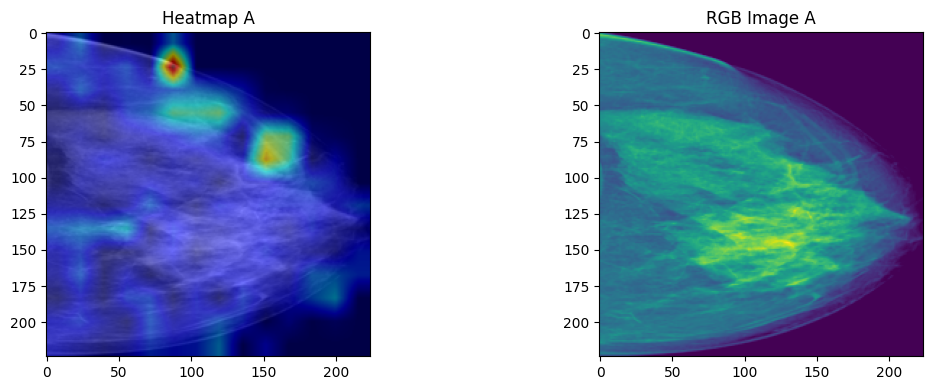

In [20]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    # Bring the channels to the first dimension
    result = result.transpose(2, 3).transpose(1, 2)
    print(result.shape)
    return result

target_layer = model.backbone.blocks[-1].norm1
#target_layer = model.backbone.blocks[-1].mlp.fc1
print(target_layer)
print(target_layer)
cam = GradCAM(model=model, target_layers=[target_layer],reshape_transform=reshape_transform)


targets = None
grayscale_cam = cam(input_tensor=x, targets=targets)
matrix = np.expand_dims(image_np, axis=2)

grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(matrix, grayscale_cam, use_rgb=True)
# Display the image

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Display the first image (heatmap A)
axes[0].imshow(visualization)
axes[0].set_title('Heatmap A')

# Display the second image (RGB image A)
axes[1].imshow(img)
axes[1].set_title('RGB Image A')

# Hiển thị các label
plt.tight_layout()
plt.show()

conpro
